# Efficiencies

In [1]:
import sys
import localSettings as ls
import os
print(ls.main_path)

/home/david/data/searchingfornues/v08_00_00_43/0702/


In [2]:
main_path = ls.main_path
sys.path.append(main_path)

In [3]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 09282020


In [4]:
from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    norm = A/(np.sqrt(2*np.pi)*sigma)
    exp  = np.exp(-((x-mu)**2)/(2*sigma*sigma))
    return norm * exp

In [5]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
#if USEBDT:
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward
import pandas as pd

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [6]:
import load_data_run123

In [7]:
def COVARIANCE(n_cv,n_var):
    cov = np.empty([len(n_cv), len(n_cv)])
    cov.fill(0)

    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            cov[i][j] += (n_var[i] - n_cv[i])*(n_var[j] - n_cv[j])

    frac_cov = np.empty([len(n_cv), len(n_cv)])
    corr = np.empty([len(n_cv), len(n_cv)])

    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            frac_cov[i][j] =  cov[i][j] / (n_cv[i] * n_cv[j])
            corr[i][j] = cov[i][j] / np.sqrt(cov[i][i] * cov[j][j])
    return cov,frac_cov,corr

In [8]:
TRAINVAR = ["shr_score","tksh_distance","tksh_angle",
            "shr_tkfit_dedx_max",
            "trkfit","trkpid",
            "subcluster","shrmoliereavg",
            "trkshrhitdist2","hits_ratio",
            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
            "CosmicIPAll3D","CosmicDirAll3D"]

LABELS =  ['pi0','nonpi0']

TRAINVARZP = ['shrmoliereavg','shr_score', "trkfit","subcluster",
              "CosmicIPAll3D","CosmicDirAll3D",
              'secondshower_Y_nhit','secondshower_Y_vtxdist','secondshower_Y_dot','anglediff_Y',
              'secondshower_V_nhit','secondshower_V_vtxdist','secondshower_V_dot','anglediff_V',
              'secondshower_U_nhit','secondshower_U_vtxdist','secondshower_U_dot','anglediff_U',
              "shr_tkfit_2cm_dedx_U", "shr_tkfit_2cm_dedx_V", "shr_tkfit_2cm_dedx_Y",
              "shr_tkfit_gap10_dedx_U", "shr_tkfit_gap10_dedx_V", "shr_tkfit_gap10_dedx_Y",
              "shrMCSMom","DeltaRMS2h","shrPCA1CMed_5cm","CylFrac2h_1cm"]

LABELSZP = ['bkg']

def loadBDT(DF):

    for label, bkg_query in zip(LABELS, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s_0304_extnumi.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            DF[label+"_score"] = booster.predict(xgb.DMatrix(DF[TRAINVAR]),
                                                 ntree_limit=booster.best_iteration)

    for label, bkg_query in zip(LABELSZP, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s_0304_extnumi_vx.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            DF[label+"_score"] = booster.predict(xgb.DMatrix(DF[TRAINVARZP]),
                                                 ntree_limit=booster.best_iteration)
            
    return

In [9]:
def loadnuevars(df):
    
    INTERCEPT = 0.0
    SLOPE = 0.83

    if (loadnues):
        df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
        df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
        df['anglediff_Y'] = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
        df['anglediff_V'] = np.abs(df['secondshower_V_dir']-df['shrclusdir1'])
        df['anglediff_U'] = np.abs(df['secondshower_U_dir']-df['shrclusdir0'])                                                                                                                       
        df["ptOverP"] = df["pt"]/df["p"]
        df["phi1MinusPhi2"] = df["shr_phi"]-df["trk_phi"]
        df["theta1PlusTheta2"] = df["shr_theta"]+df["trk_theta"]
        df['cos_shr_theta'] = np.cos(df['shr_theta'])
        df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])                                                                                                                                                                                              
        df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])                                                                                                                                                              
        df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])                                                                                                                             
        df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
        df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
        df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
        df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
        df['electron_e'] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE


        loadBDT(df)

In [10]:
loadnues  = False
loadnumus = True

In [11]:
# nue variables



if (loadnues):
    PATH = '/home/david/data/searchingfornues/v08_00_00_44/'
    mcCV   = 'nue_CV.root'
    mcLYD  = 'nue_LYDown.root'
    mcLYR  = 'nue_LYRayleigh.root'
    mcLYA  = 'nue_LYAttenuation.root'
    mcX    = 'nue_ScaleX.root'
    mcYZ   = 'nue_ScaleYZ.root'
    mcAXZ  = 'nue_AngleXZ.root'
    mcAYZ  = 'nue_AngleYZ.root'
    mcSCE  = 'nue_SCE.root'
    mcdEdX = 'nue_dEdX.root'
    
if (loadnumus):
    
    PATH = '/home/david/data/searchingfornues/v08_00_00_44/0724/noweights/'
    mcCV   = 'prodgenie_bnb_nu_overlay_DetVar_CV_reco2_v08_00_00_38_run3b_reco2_reco2.root'
    mcLYD  = 'prodgenie_bnb_nu_overlay_DetVar_LYDown_v08_00_00_37_v2_run3b_reco2_reco2.root'
    mcLYR  = 'prodgenie_bnb_nu_overlay_DetVar_LYRayleigh_v08_00_00_37_run3b_reco2_reco2.root'
    mcLYA  = 'prodgenie_bnb_nu_overlay_DetVar_LYAttenuation_v08_00_00_38_run3b_reco2_reco2.root'
    mcX    = 'prodgenie_bnb_nu_overlay_DetVar_wiremod_ScaleX_v08_00_00_38_run3b_reco2_reco2.root'
    mcYZ   = 'prodgenie_bnb_nu_overlay_DetVar_WireModAngleYZ_v08_00_00_38_exe_run3b_reco2_reco2.root'
    mcAXZ  = 'prodgenie_bnb_nu_overlay_DetVar_WireModAngleXZ_v08_00_00_38_exe_run3b_reco2_reco2.root'
    mcAYZ  = 'prodgenie_bnb_nu_overlay_DetVar_WireModAngleYZ_v08_00_00_38_exe_run3b_reco2_reco2.root'
    mcSCE  = 'prodgenie_bnb_nu_overlay_DetVar_SCE_reco2_v08_00_00_38_run3b_reco2_reco2.root'
    mcdEdX = 'prodgenie_bnb_nu_overlay_DetVar_wiremod_ScaledEdX_v08_00_00_39_run3b_reco2_reco2.root'

In [12]:
#DETVAR_N_V = ["X", "YZ", 'aYZ', "aXZ"]#,"dEdX","SCE","LYD","LYR","LYA"]
#DETVAR_S_V = [mcX,mcYZ,mcAYZ,mcAXZ]#,nuedEdX,nueSCE,nueLYD,nueLYR,nueLYA]

#DETVAR_N_V = ["dEdX","SCE"]
#DETVAR_S_V = [mcdEdX,mcSCE]

#DETVAR_N_V = ["LYD","LYR","LYA"]
#DETVAR_S_V = [mcLYD,mcLYR,mcLYA]

DETVAR_N_V = ["X", "YZ", 'aYZ', "aXZ","dEdX","SCE","LYD","LYR","LYA"]
DETVAR_S_V = [mcX,mcYZ,mcAYZ,mcAXZ,mcdEdX,mcSCE,mcLYD,mcLYR,mcLYA]

In [13]:
fold = 'nuselection'
tree = 'NeutrinoSelectionFilter'

In [14]:
VARDICT = load_data_run123.get_variables()

In [16]:
if (loadnues):
    variables = VARDICT['VARIABLES'] + VARDICT['NUEVARS'] #+ load_data_run123.RCVRYVARS
if (loadnumus):
    # numus
    variables = VARDICT['VARIABLES'] + VARDICT['CRTVARS']

In [18]:
# Central Value DF
CV = uproot.open(PATH+mcCV)[fold][tree]
CVDF  = CV.pandas.df(variables, flatten=False)


if (loadnues):
    load_data_run123.process_uproot(CV,CVDF)
    loadnuevars(CVDF)
if (loadnumus):
    load_data_run123.process_uproot_numu(CV,CVDF)

CVDF['bnbdata']  = np.zeros_like(CVDF['nslice'])
CVDF['extdata']  = np.zeros_like(CVDF['nslice'])


CVDF['identifier'] = CVDF['run']*100000 + CVDF['evt']  + ((100.*CVDF['nu_e']).astype(int))/1000. #to line up events with sample events

NCV = CVDF.shape[0]

print ('there are %i CV events'%(CVDF.shape[0]))

DETSYS_SAMPLE_V = [] #list of merged CV-VAR dfataframes
POT_V = [] #POT of samples? Not really used elsewhere

for i,N in enumerate(DETVAR_N_V):
    
    VAR = uproot.open(PATH+DETVAR_S_V[i])[fold][tree]
    VARDF = VAR.pandas.df(variables, flatten=False)
    
    VARDF['bnbdata']  = np.zeros_like(VARDF['nslice'])
    VARDF['extdata']  = np.zeros_like(VARDF['nslice'])

    
    if (loadnues):
        loadnuevars(VARDF)
        load_data_run123.process_uproot(VAR,VARDF)
    if (loadnumus):
        load_data_run123.process_uproot_numu(VAR,VARDF)

    VARDF['identifier'] = VARDF['run']*100000 + VARDF['evt']  + ((100.*VARDF['nu_e']).astype(int))/1000.     
    INT = pd.merge(CVDF, VARDF, how='inner', on=['identifier'],suffixes=('_CV', '_VAR'))

    print ('intersection for %15s variation has %i events'%(DETVAR_N_V[i],INT.shape[0]))
    DETSYS_SAMPLE_V.append(INT)
    
    #break

/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: overflow encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)


there are 82859 CV events
intersection for               X variation has 82855 events
intersection for              YZ variation has 85053 events
intersection for             aYZ variation has 85053 events
intersection for             aXZ variation has 81214 events
intersection for            dEdX variation has 79418 events
intersection for             SCE variation has 75006 events
intersection for             LYD variation has 80035 events
intersection for             LYR variation has 80973 events
intersection for             LYA variation has 79806 events


In [19]:
def _selection(variable, sample, query="selected==1"):#, extra_cut='',verbose=False):
    """
    variable: string, about which info to be returned
    sample: dataframe, to be queried
    query: string, event-level queries
    extra_cut: string, just another cut in addition to query
    select_longest: bool, will select longest track in each slice after cuts
        should be on when variable is track-level
    fix: string, should be "_CV" or "_VAR"
        on which sample to apply the cuts
    return_fix: string, should be "_CV" or "_VAR"
        which sample to return
    
    Returns an array of track/event variables that pass cuts
    """
        
    df = sample.copy().query(query)
    #start dealing with the track variables
    VARS = df[variable]#VARS is not clean of empty frames
    
    return VARS

In [28]:
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

plt.rcParams.update({'font.size': 14})

import unblinding_far_sideband
importlib.reload(unblinding_far_sideband)

import detsysselections
importlib.reload(detsysselections)

<module 'detsysselections' from '/home/david/Neutrinos/NUE/PELEE3/detsysselections.py'>

In [29]:
if (loadnues):

    sdb_key = 'None'
    pre_key = 'NP'
    sel_key = 'NPBDT'

    QUERY_CV  = detsysselections.BDTCQ("CV")
    QUERY_VAR = detsysselections.BDTCQ("VAR")

if (loadnumus):    
    
    sdb_key = 'None'
    pre_key = 'NUMU'
    sel_key = 'NUMU'

    QUERY_CV  = detsysselections.NUMUSEL("CV")
    QUERY_VAR = detsysselections.NUMUSEL("VAR")
    
sideband = unblinding_far_sideband.sideband_categories[sdb_key]
preselection = unblinding_far_sideband.preselection_categories[pre_key]
sel =  unblinding_far_sideband.selection_categories[sel_key]

SAVEPATH = ls.main_path+'/detsys/'+'{}_{}_{}/'.format(sideband['dir'], preselection['dir'], sel['dir'])

if not os.path.exists(SAVEPATH):
    os.makedirs(SAVEPATH)

In [30]:
SAVEFIG = True

In [33]:
if (loadnues):
    plot_variables  = unblinding_far_sideband.kinematic_variables
    plot_variables += unblinding_far_sideband.energy_variables
    plot_variables += unblinding_far_sideband.bdt_common_variables_1eNp
    plot_variables += unblinding_far_sideband.bdt_1enp_variables
if (loadnumus):
    #plot_variables  = unblinding_far_sideband.numupresel_variables
    plot_variables = unblinding_far_sideband.numusel_variables    

[0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35 1.45
 1.55]
starting X...
n CV  :  [ 908. 1283. 1009.  612.  431.  300.  192.  160.  124.   90.   57.   35.
   19.   13.]
n VAR :  [ 906. 1284. 1002.  632.  419.  299.  181.  167.  121.   86.   59.   33.
   22.   12.]


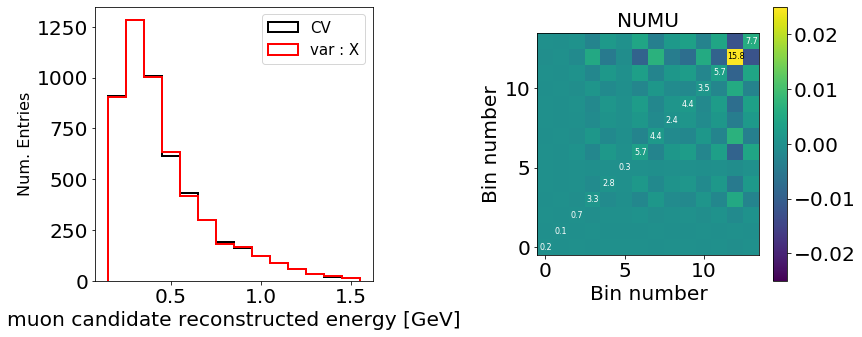

starting YZ...
n CV  :  [ 952. 1307. 1038.  614.  439.  316.  201.  163.  133.   92.   53.   35.
   19.   12.]
n VAR :  [ 948. 1295. 1013.  631.  437.  306.  200.  167.  130.   94.   54.   33.
   19.   12.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


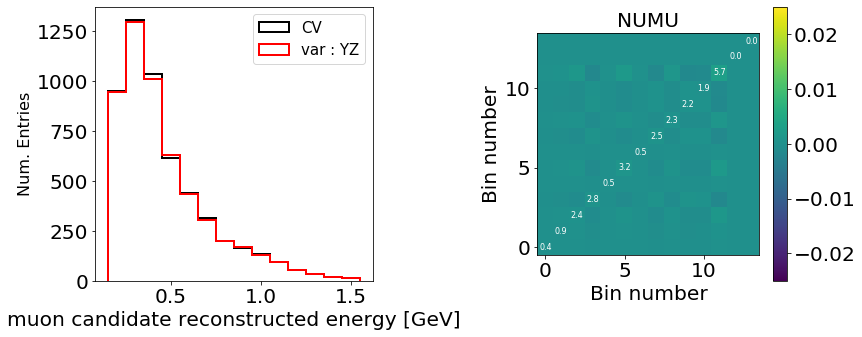

starting aYZ...
n CV  :  [ 952. 1307. 1038.  614.  439.  316.  201.  163.  133.   92.   53.   35.
   19.   12.]
n VAR :  [ 948. 1295. 1013.  631.  437.  306.  200.  167.  130.   94.   54.   33.
   19.   12.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


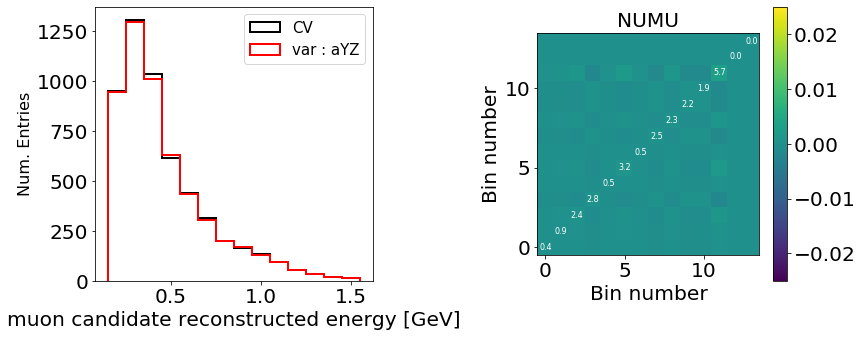

starting aXZ...
n CV  :  [ 894. 1266.  992.  587.  420.  300.  191.  160.  119.   87.   54.   34.
   18.   12.]
n VAR :  [ 893. 1260.  951.  597.  409.  299.  191.  160.  120.   84.   59.   32.
   21.   11.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


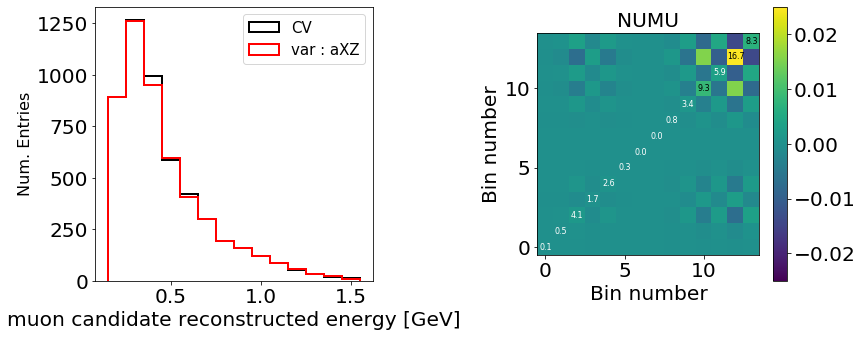

starting dEdX...
n CV  :  [ 872. 1242.  975.  575.  416.  294.  189.  153.  120.   90.   50.   36.
   19.   12.]
n VAR :  [ 841. 1235.  958.  553.  402.  291.  188.  158.  121.   83.   54.   37.
   19.   13.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


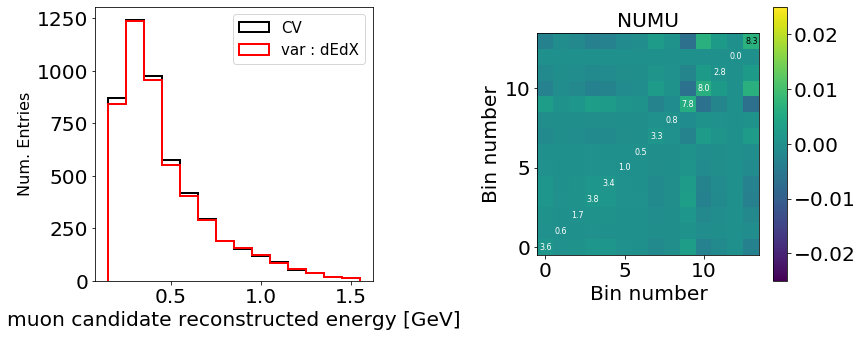

starting SCE...
n CV  :  [ 839. 1177.  921.  557.  367.  274.  168.  142.  108.   81.   46.   30.
   15.   13.]
n VAR :  [ 909. 1177.  926.  554.  367.  277.  165.  139.  106.   73.   51.   28.
   16.   10.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


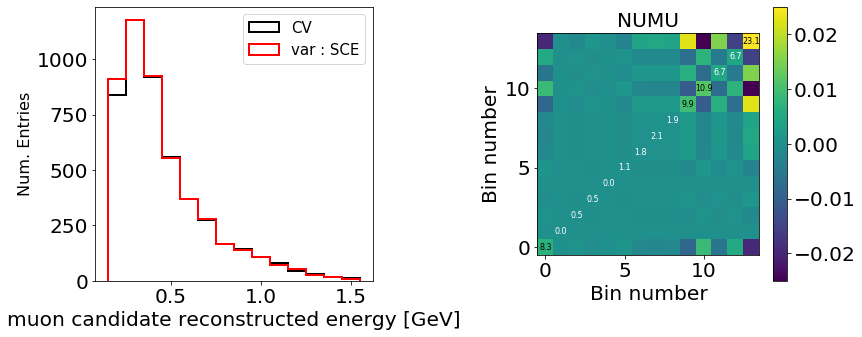

starting LYD...
n CV  :  [ 888. 1225.  990.  576.  415.  292.  189.  155.  118.   85.   54.   35.
   17.   12.]
n VAR :  [ 891. 1226.  987.  570.  408.  293.  187.  153.  117.   83.   54.   33.
   17.   11.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


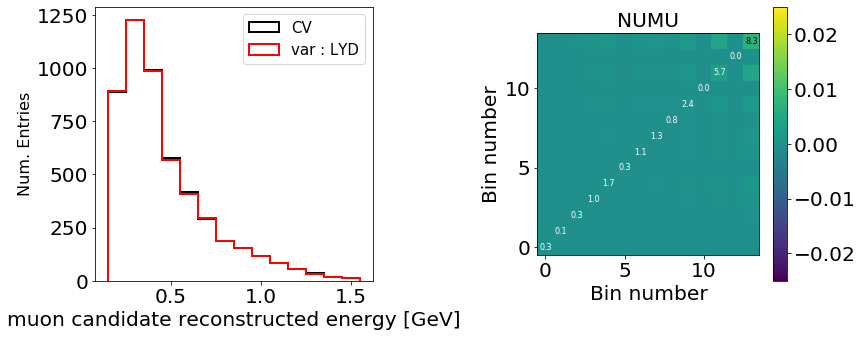

starting LYR...
n CV  :  [ 903. 1254.  987.  590.  417.  290.  184.  156.  120.   90.   52.   34.
   18.   12.]
n VAR :  [ 895. 1252.  986.  588.  416.  292.  187.  157.  120.   90.   52.   35.
   18.   13.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


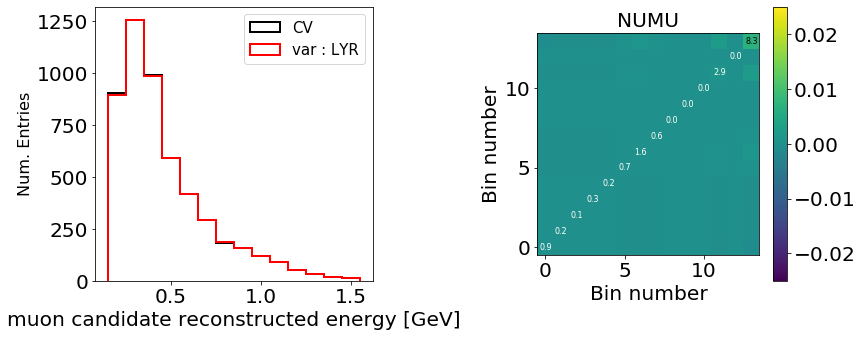

starting LYA...
n CV  :  [ 899. 1221.  976.  586.  405.  285.  184.  156.  117.   87.   50.   34.
   19.   13.]
n VAR :  [ 890. 1205.  961.  572.  392.  283.  179.  154.  116.   80.   49.   33.
   19.   12.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


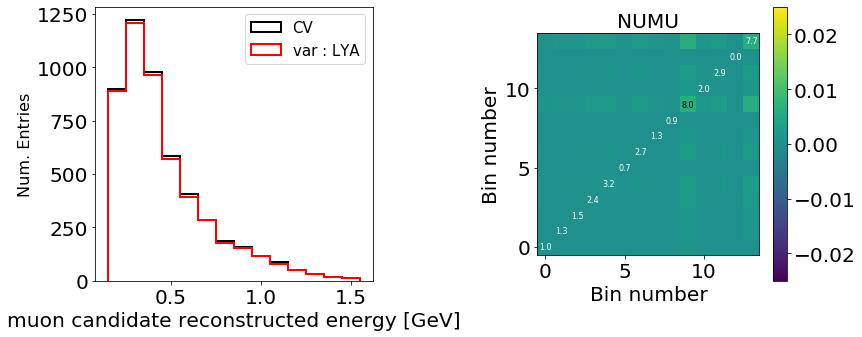

starting X...
n CV  :  [102. 271. 470. 537. 574. 557. 505. 451. 407. 310. 216. 188. 125.  74.]
n VAR :  [ 99. 273. 467. 541. 580. 571. 503. 443. 399. 313. 211. 176. 136.  69.]


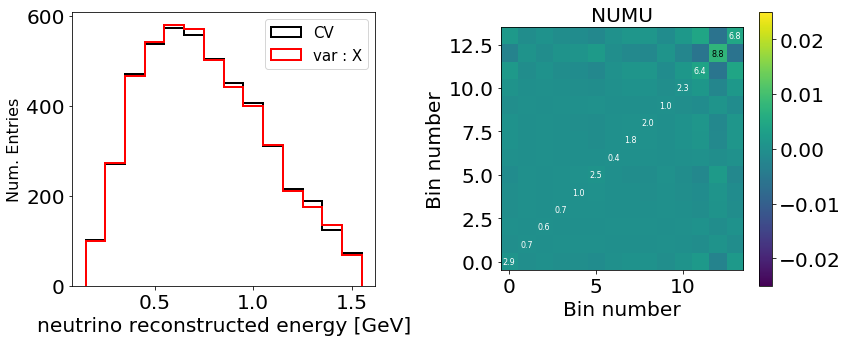

starting YZ...
n CV  :  [105. 272. 478. 549. 593. 581. 515. 469. 427. 311. 218. 192. 129.  75.]
n VAR :  [103. 285. 468. 544. 582. 590. 510. 457. 416. 304. 220. 191. 128.  76.]


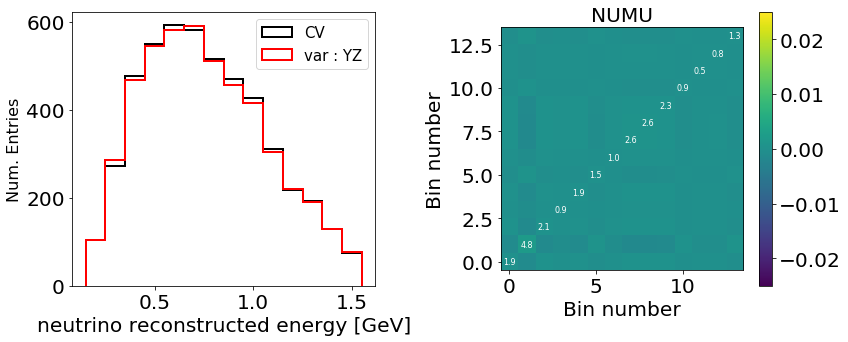

starting aYZ...
n CV  :  [105. 272. 478. 549. 593. 581. 515. 469. 427. 311. 218. 192. 129.  75.]
n VAR :  [103. 285. 468. 544. 582. 590. 510. 457. 416. 304. 220. 191. 128.  76.]


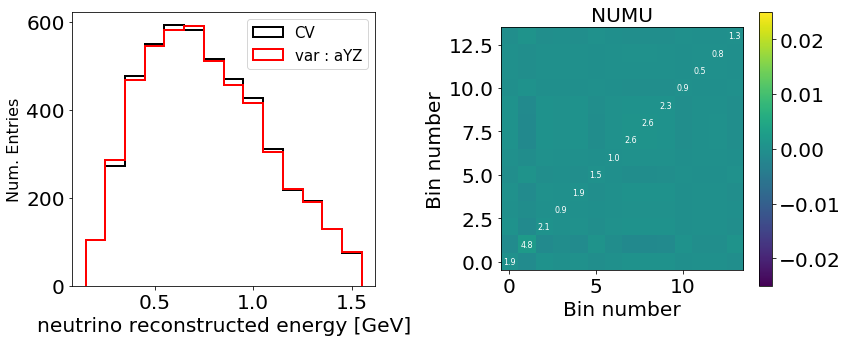

starting aXZ...
n CV  :  [ 96. 268. 463. 523. 562. 560. 499. 443. 398. 294. 207. 183. 123.  72.]
n VAR :  [ 93. 283. 435. 530. 551. 549. 477. 467. 379. 301. 209. 176. 133.  80.]


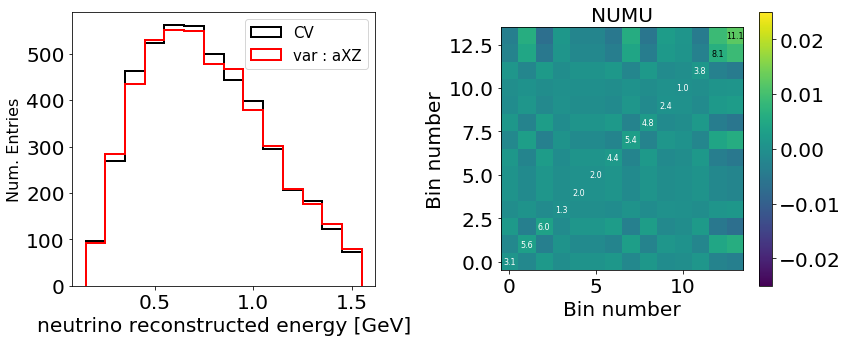

starting dEdX...
n CV  :  [ 99. 264. 454. 509. 564. 554. 477. 427. 388. 291. 202. 176. 128.  73.]
n VAR :  [ 99. 265. 445. 510. 549. 537. 448. 426. 370. 278. 210. 175. 120.  89.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


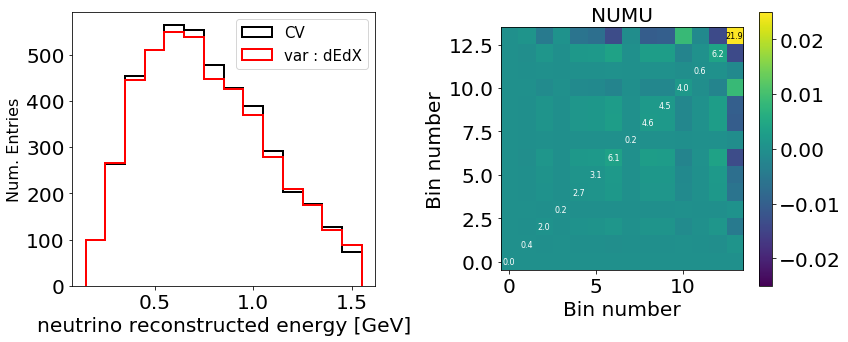

starting SCE...
n CV  :  [ 92. 251. 433. 465. 514. 526. 456. 426. 355. 282. 198. 159. 116.  66.]
n VAR :  [ 93. 261. 443. 492. 512. 517. 471. 428. 349. 264. 203. 163. 120.  72.]


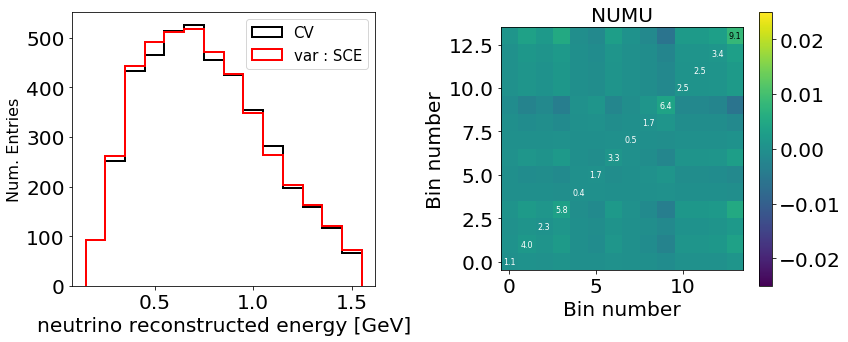

starting LYD...
n CV  :  [102. 266. 456. 511. 554. 556. 475. 443. 390. 294. 201. 177. 124.  67.]
n VAR :  [ 99. 281. 467. 511. 549. 542. 477. 437. 388. 290. 195. 177. 124.  66.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


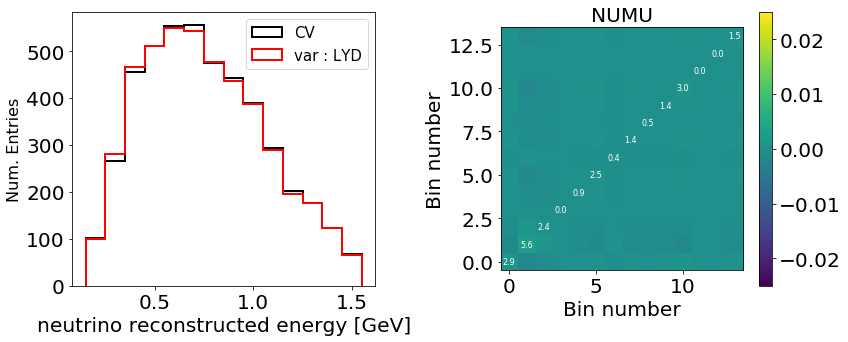

starting LYR...
n CV  :  [100. 267. 456. 527. 558. 554. 494. 440. 394. 297. 204. 182. 125.  67.]
n VAR :  [ 93. 266. 469. 521. 560. 547. 492. 437. 393. 298. 206. 182. 125.  67.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


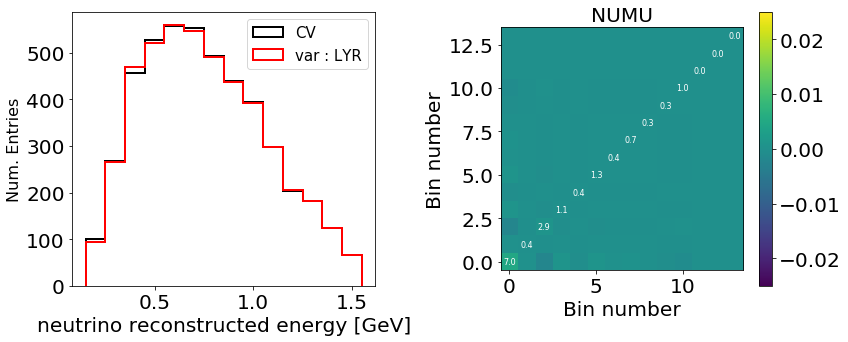

starting LYA...
n CV  :  [ 97. 264. 450. 524. 556. 538. 487. 439. 392. 287. 198. 178. 113.  68.]
n VAR :  [ 96. 270. 447. 520. 543. 530. 484. 426. 384. 281. 190. 175. 112.  63.]


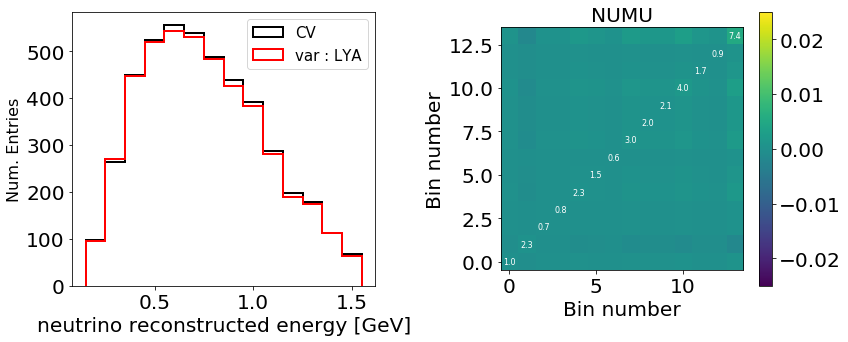

starting X...
n CV  :  [  71.   55.   35.   48.   47.   62.   57.   51.   60.   56.   56.   64.
   58.   83.   93.   89.  127.  162.  181.  165.  220.  225.  280.  279.
  371.  480.  740. 1041.]
n VAR :  [  69.   60.   40.   53.   50.   53.   53.   59.   58.   53.   49.   70.
   56.   82.   97.   87.  141.  164.  185.  169.  218.  217.  295.  285.
  352.  469.  724. 1039.]


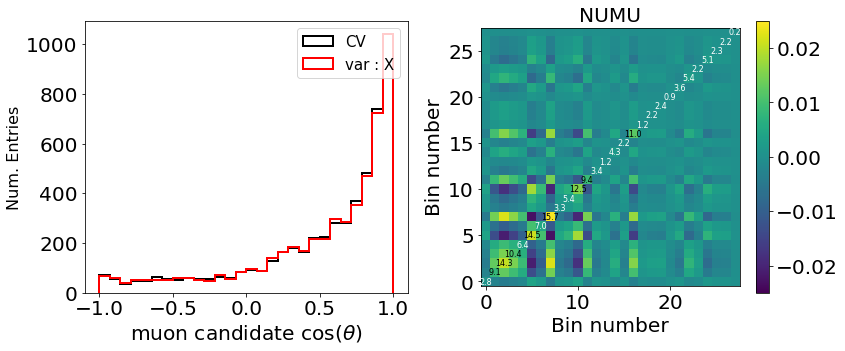

starting YZ...
n CV  :  [  74.   58.   36.   51.   46.   61.   58.   49.   64.   55.   58.   70.
   55.   82.   91.   93.  126.  165.  178.  180.  222.  238.  284.  296.
  387.  491.  759. 1070.]
n VAR :  [  70.   51.   36.   54.   45.   58.   54.   53.   65.   54.   58.   66.
   54.   90.   98.   98.  137.  159.  175.  179.  225.  239.  287.  309.
  379.  497.  741. 1030.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


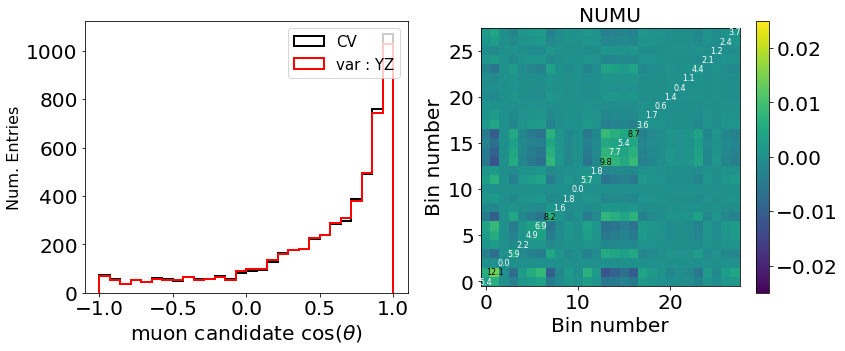

starting aYZ...
n CV  :  [  74.   58.   36.   51.   46.   61.   58.   49.   64.   55.   58.   70.
   55.   82.   91.   93.  126.  165.  178.  180.  222.  238.  284.  296.
  387.  491.  759. 1070.]
n VAR :  [  70.   51.   36.   54.   45.   58.   54.   53.   65.   54.   58.   66.
   54.   90.   98.   98.  137.  159.  175.  179.  225.  239.  287.  309.
  379.  497.  741. 1030.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


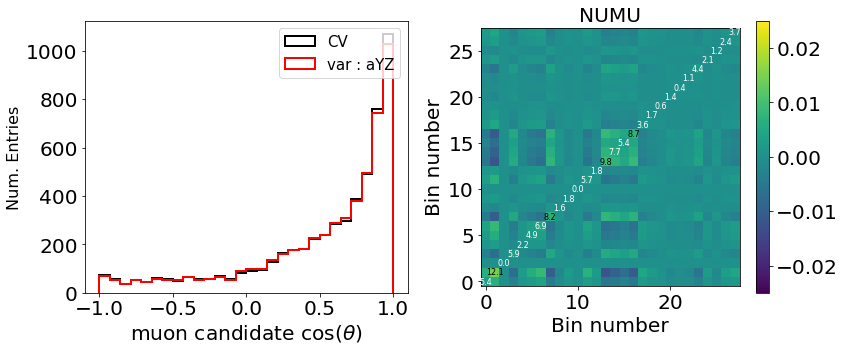

starting aXZ...
n CV  :  [  68.   56.   35.   49.   44.   60.   53.   48.   62.   56.   56.   64.
   57.   81.   90.   87.  125.  156.  173.  168.  214.  220.  273.  282.
  371.  469.  716. 1025.]
n VAR :  [  65.   54.   37.   54.   46.   54.   53.   49.   66.   57.   59.   59.
   61.   78.   86.   84.  134.  144.  171.  176.  212.  211.  283.  287.
  366.  463.  685. 1016.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


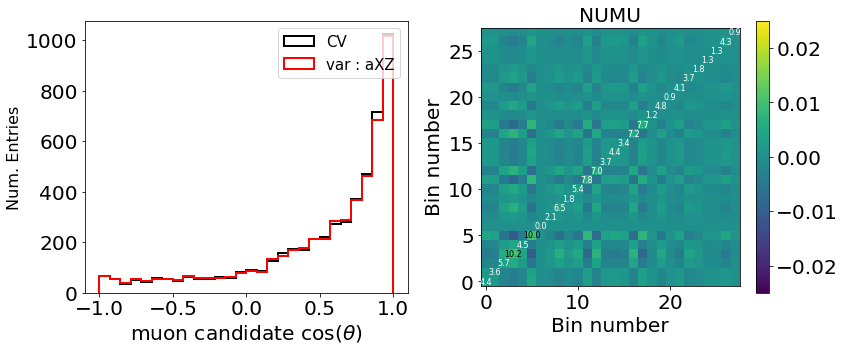

starting dEdX...
n CV  :  [ 70.  54.  35.  49.  41.  59.  55.  47.  62.  54.  52.  63.  55.  77.
  88.  90. 125. 150. 175. 171. 196. 215. 271. 275. 364. 472. 704. 998.]
n VAR :  [ 70.  50.  38.  51.  43.  58.  49.  51.  61.  50.  47.  61.  53.  63.
  91.  87. 121. 150. 169. 168. 201. 215. 267. 297. 342. 475. 673. 974.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


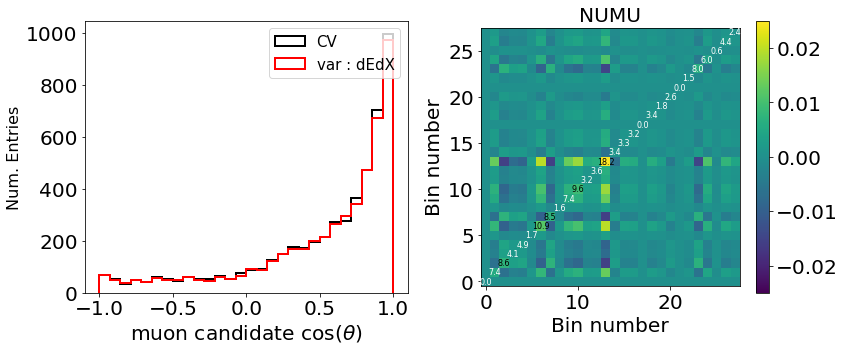

starting SCE...
n CV  :  [ 67.  50.  33.  46.  45.  54.  51.  51.  62.  49.  56.  57.  55.  75.
  83.  80. 116. 141. 168. 148. 195. 207. 254. 257. 340. 433. 653. 932.]
n VAR :  [ 65.  50.  42.  48.  43.  55.  49.  54.  61.  46.  52.  46.  54.  89.
  76.  86. 125. 137. 177. 170. 198. 199. 266. 269. 329. 432. 655. 945.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


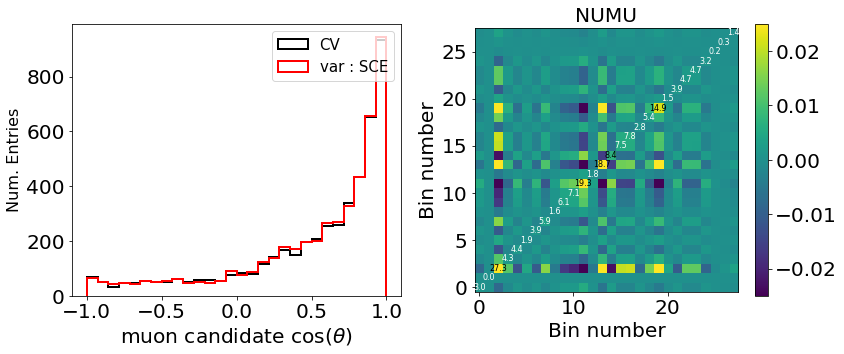

starting LYD...
n CV  :  [  64.   51.   35.   47.   47.   59.   52.   46.   64.   55.   56.   62.
   52.   77.   95.   83.  122.  158.  167.  168.  208.  217.  268.  269.
  368.  463.  706. 1017.]
n VAR :  [  64.   50.   36.   47.   47.   60.   53.   48.   64.   53.   56.   58.
   54.   77.   97.   83.  122.  148.  164.  167.  206.  216.  271.  267.
  372.  463.  703. 1008.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


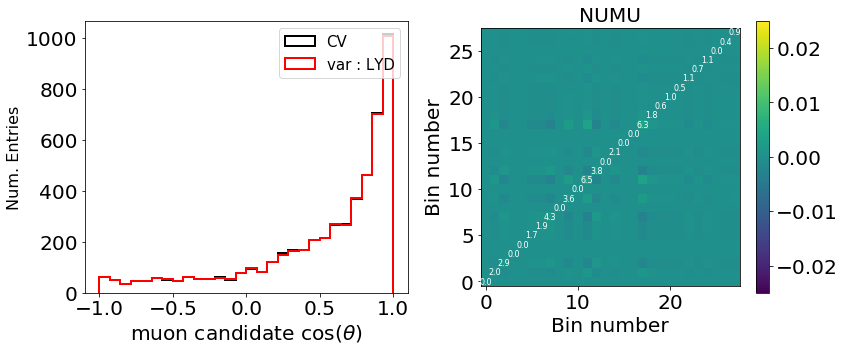

starting LYR...
n CV  :  [  69.   51.   35.   49.   44.   58.   55.   49.   60.   54.   52.   64.
   55.   82.   87.   84.  129.  157.  169.  171.  208.  219.  277.  285.
  368.  467.  713. 1020.]
n VAR :  [  71.   51.   36.   48.   44.   56.   55.   50.   59.   52.   52.   64.
   54.   79.   89.   82.  130.  156.  163.  168.  209.  219.  281.  289.
  369.  470.  713. 1016.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


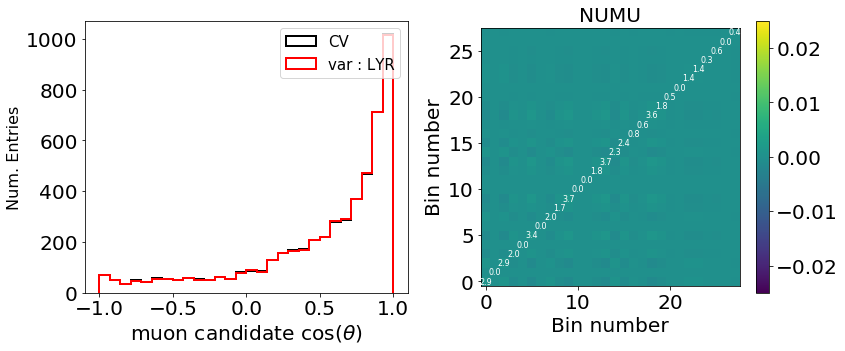

starting LYA...
n CV  :  [  69.   56.   36.   51.   46.   57.   53.   50.   62.   54.   56.   59.
   52.   81.   89.   84.  126.  154.  168.  163.  204.  220.  259.  281.
  364.  454.  699. 1010.]
n VAR :  [ 72.  55.  38.  50.  44.  55.  51.  49.  60.  51.  56.  56.  55.  77.
  91.  83. 124. 144. 161. 157. 195. 213. 260. 282. 360. 444. 687. 997.]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


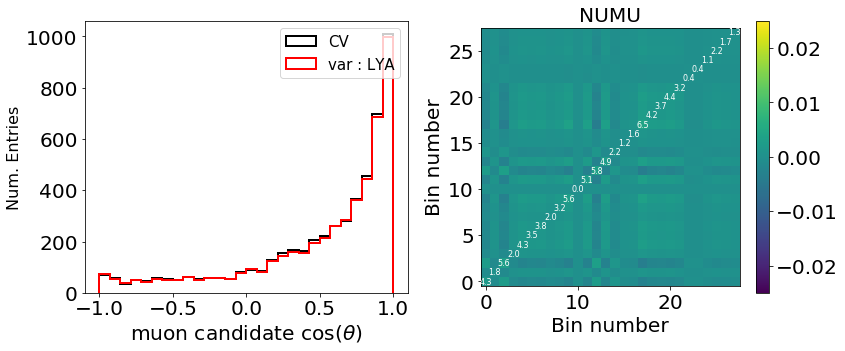

In [34]:
importlib.reload(ls)

#choose what you want to show
VARIABLE = 'reco_e'
TITLE = r'reconstructed neutrino energy [GeV]'
BINEDGES = np.linspace(0.15,1.55,15)

print (BINEDGES)

for VARIABLE,NBINS,RANGE,TITLE in plot_variables:
    
    BINEDGES = np.linspace(RANGE[0],RANGE[1],NBINS+1)

    #output errors
    ERROR_OUT_V = []
    QUAD_ERROR_V = np.zeros(len(BINEDGES)-1)

    #fig = plt.figure(figsize=(20,3*len(DETVAR_N_V)))

    for idx,df_perm in enumerate(DETSYS_SAMPLE_V):
        df = df_perm.copy()
        print("starting {}...".format(DETVAR_N_V[idx]))

        VARS_CV = _selection(VARIABLE+'_CV',df,QUERY_CV)

        VARS_VAR = _selection(VARIABLE+'_VAR',df,QUERY_VAR)

        #######################################
        fig = plt.figure(figsize=(12,5))
        gs = fig.add_gridspec(1, 2)

        axis = fig.add_subplot(gs[0, 0])    
        ################################
        # CV-VAR histogram comparison
        #get queried arrays of the variable
        #get number of entries in each bin for each sample. and plot hists
        n_cv, bins, p = axis.hist(VARS_CV ,bins=BINEDGES,histtype='step',\
                                  lw=2,color='k',label='CV')
        n_var, bins, p = axis.hist(VARS_VAR,bins=BINEDGES,histtype='step',\
                                   lw=2,color='r',label='var : %s'%DETVAR_N_V[idx])

        print ('n CV  : ',n_cv)
        print ('n VAR : ',n_var)

        bc = 0.5*(bins[1:]+bins[:-1]) #bin centers

        cov,frac_cov,corr = COVARIANCE(n_cv,n_var) #calculate various matrices
        error = np.sqrt(np.diag(frac_cov)) #systematic error is this

        if (DETVAR_N_V[idx] != "Recomb"):
            ERROR_OUT_V.append(error)
            QUAD_ERROR_V += np.diag(frac_cov)

        axis.set_xlabel(TITLE)
        axis.set_ylabel('Num. Entries',fontsize=16)
        #plt.ylim(0,plt.gca().get_ylim()[1]*1.5)
        axis.legend(fontsize=15,loc="best")
        #plt.title(SAMPLE)

        ########################################
        axis = fig.add_subplot(gs[0, 1])
        #####################################
        # Fractional Covariance
        #be consistent when comparing multiple plots
        pos = axis.imshow(frac_cov, origin='lower', cmap='viridis',vmin=-0.025,vmax=0.025) 
        #print values onto the plot
        # Limits for the extent
        x_start = 0
        x_end = len(n_cv)#-1
        y_start = 0
        y_end = len(n_cv)#-1
        size = len(n_cv)#-1
        jump_x = (x_end - x_start) / (2.0 * size)
        jump_y = (y_end - y_start) / (2.0 * size)
        x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
        y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)
        for x_index, x in enumerate(x_positions):
            #for x_index, x in enumerate(x_positions):
            ERR = frac_cov[x_index, x_index]
            label = "{:.1f}".format(100.*np.sqrt(ERR))
            text_x = x #+ jump_x
            text_y = x #+ jump_y
            if (100.*np.sqrt(ERR) > 8):
                axis.text(text_x, text_y, label, color='black', ha='center', va='center',fontsize=8)
            else:
                axis.text(text_x, text_y, label, color='white', ha='center', va='center',fontsize=8)
        fig.colorbar(pos, ax=axis)
        axis.set_ylabel("Bin number")
        axis.set_xlabel("Bin number")
        axis.set_title(sel_key)


        plt.tight_layout()
        plt.show()

        if (SAVEFIG):
            fig.savefig(SAVEPATH+VARIABLE+"_%s.pdf"%(DETVAR_N_V[idx]))

            # diagonal errors
            fout = open(SAVEPATH+VARIABLE+"_%s.txt"%(DETVAR_N_V[idx]),'w')
            for i,e in enumerate(error):
                fout.write('%.02f - %.02f, %.03f \n'%(BINEDGES[i],BINEDGES[i+1],e))
            fout.close()
            # covariance matrix
            fout = open(SAVEPATH+VARIABLE+"_%s_cov.txt"%(DETVAR_N_V[idx]),'w')
            string = ''
            for n in range(len(error)):
                string += '%.02f-%.02f, '%(BINEDGES[n],BINEDGES[n+1])
            string += '\n'
            fout.write(string)
            for i in range(len(error)):
                string = '%.02f-%.02f, '%(BINEDGES[i],BINEDGES[i+1])
                for j in range(len(error)):
                    string += '%.04f, '%frac_cov[i,j]
                string += '\n'
                fout.write(string)
            fout.close()


    #SAVEFIG = False

    #print (ERROR_OUT_V)
    #print (np.array(np.sqrt(QUAD_ERROR_V)))